## 09.AWS Hyperparameter Tuning job for XGBoost Classification

Purpose: Based on the configured list of hyperparameters ranges and input taining data perform Bayesian or Random  tuning job for XGBoost Classification.

Single model training or CV with standard or custom evaluation metrics can be used.

OpenSource XGBoost is used in the script and it can be replaced with SageMaker built-in XGBoost only for single model training with standard evaluation metric. 

The notebook uses the same scripts for models training as 01.AWS...Training Model....py and 02.AWS...CV....py 

#### Custom training script output

Only in OpenSource XGBoost custom evaluation metrics can be defined and used for model training directly in the script used for training. However, AWS SageMaker hyperparameter tuning job do not see them. Custom evaluation metrics should be configured in metric_defintions.

OpenSource SageMaker XGBoost (as in March 2021 version 1.2-1) is incorrectly recognizing XGBoost as a built-in algorithm and using metric definition raise the error:
An error occurred (ValidationException) when calling the CreateTrainingJob operation: You can't override the metric definitions for Amazon SageMaker algorithms. Please retry the request without specifying metric definitions.

CV output looks different from training output even if we use  standard XGBoost metrics (ROC-AUC). There is "test" instead of "validation": 

[1060]#011train-auc:0.72230+0.00097#011test-auc:0.69244+0.01114

AWS SageMaker hyperparameter tuning job does not recognize the output.

There are 2 approached to make AWS SageMaker fully functional.

**The first one is just to name the custom function as a standard one.**

The trick is:
1. Create a function to calculate custom metric (gini). If it's named gini it will be used in training but NOT visible for experiments or hyperparameters tuning.
2. Name it as a standard score (auc_xgb instead of gini_xgb) 
3. Disable using a standard score in the parameters: 'disable_default_eval_metric': '1', and do not add eval_metric at all.

For CV:

Adjust callback functions ooutput in CV  to make it identical to the train output. This is relatively simple option. We may even use a custom evaluation function, just name it like a standard function: accuracy, auc, etc 

That's easily can be accomplished just in the script used for training.

This option is not used in the notebook, but can be implemented easily with adjusting if statement based on entry_point.

**The second approach is more complex and require more efforts**

You need to register custom metrics with metric_defintions (https://docs.aws.amazon.com/sagemaker/latest/dg/training-metrics.html#define-train-metrics-sdk).
 
As on Mar/2021 open source, script mode, AWS SageMaker XGBoost is still recognized like a standard, built-in algorithm and prevent us using custom metric definitions.
See https://github.com/aws/sagemaker-xgboost-container/issues/121

The workaround is to create your own container from the official AWS Sagemaker Open Source XGBoost GitHub repository, host it in your own ECR repository, and use this image from Python SDK. 

**Steps to create your own ECR repository:**

1. Install and configure aws-cli (https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-install.html and https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-configure.html)

2. Install docker (https://docs.docker.com/engine/install/ubuntu/) or just add your user to the docker group (Some steps below do not work when docker used via sudo)
- sudo usermod -aG docker kate
Activate the changes to groups
- newgrp docker
Verify that you can run docker commands without sudo
- docker run hello-world
3. Build container
- git clone https://github.com/aws/sagemaker-xgboost-container
- docker build -t xgboost-container-base:1.2-1-cpu-py3 -f docker/1.0-1/base/Dockerfile.cpu .
- python setup.py bdist_wheel --universal
- docker build -t preprod-xgboost-container:1.2-1-cpu-py3 -f docker/1.2-1/final/Dockerfile.cpu .
4. Create ECR repository and push the above image.
- eval $(aws ecr get-login --region  us-west-2 --no-include-email | sed 's|https://||')
- aws ecr create-repository --repository-name sagemaker-xgboost --region us-west-2
- docker tag preprod-xgboost-container:1.2-1-cpu-py3 XYZ.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost:1.2-1-cpu-py3
- docker push XYZ.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost:1.2-1-cpu-py3
5. Use image_uri=XYZ.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost:1.2-1-cpu-py3 in XGBoost()


#### Notebook Main steps:

1. Experiment configuration. Instead of hardcoding datafile name, target variable, hyperparameters ranges directly in the code I use an Excel file. Each tab with a predefined name contains hyperparameters ranges or an input filename. At the end, the code records the results back into the same excel file. Excel is used as an UI to easily configure experiment and simplify re-use of this notebook

AWS SageMaker Experiment is not used directly in hyperparameter tuning job. There is a code in the notebook to record all tuning training jobs in an experiment but I do not see a lot of gain from this.

2. Running tuning job.


3. Extracting results, visualization and saving to an experiment log file.  


#### Known issues:
1. Warnings after upgrading SageMaker to version 2:
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
Looks like warnings from XGBoost open-source estimator. No clear information about the parameters
2. All models artifacts (debugging info) are saved into output_path provided as a parameter to the estimator (expected only model.tar.gz) except source/sourcedir.tar.gz which is saved into root of a bucket from output_path. Previously everything except model.tar.gz was saved into default bucket. This is entry_point (training) script and the path is defined in SM_MODULE_DIR environment variable but there is no clue how to change it. 
3. As on Mar/2021 open source, script mode, AWS SageMaker XGBoost is still recognized like a standard, built-in algorithm and prevent us using custom metric definitions.
See https://github.com/aws/sagemaker-xgboost-container/issues/121

In [72]:
temp_folder='/home/kate/Research/Property/Notebooks/Experiments/tmp/'
Experiments_file='/home/kate/Research/Property/Notebooks/Experiments/Logs/Set1-Classification.xlsx'
AllExperiments_tab='Experiments'
#Experiment name will be used as Hyperparameter job name
Experiment_name='HyperParams'
#1. Experiment configuration: the same dataset is used in all trial omponents
Experiment_InputData='%s InputData'%Experiment_name
#2. HyperParam configuration: min, max value and type: ContinuousParameterRanges, IntegerParameterRanges
#If MinValue=MaxValue it's a static parameter and will not be added into tuning job but into models directly
Experiment_models='%s Ranges'%Experiment_name

Trial_name='%s-TrainingModels'%Experiment_name 



#model in
bucket='kdproperty'

#instance type to be created for training jobs. 
instance_type='ml.c5.xlarge'

strategy='Bayesian' #Random
#how many total training jobs to run in the tuning process
max_jobs=100

#how many jobs to run in parallel
max_parallel_jobs=2

#data in training and testing file type
content_type='text/csv'

path_to_models='Models/Experiments/%s'%Experiment_name


#entry_point defines a script to be run for model training
#the scripts have different ouput and metric defnitions as well as the objective metric should be adjusted accordingly
entry_point='ModelCV_Gini_EvalMetric.py' #'ModelTraining.py' #uses a standard XGBoost metric (auc), no need for custom image_uri in XGBoost and metric definition, objective is validation:auc
# ModelTraining_Gini_EvalMetric.py uses XGBoost training with custom evaluation metric - gini. Use custom image_uri and metric defnitions. Objective should be adjusted to validation:gini
# ModelCV.py uses XGBoost CV to return the final, standard, evaluation metric - auc. Use custom image_uri and metric defnitions. Objective should be adjusted to test:auc
# ModelCV_Gini_EvalMetric.py uses XGBoost CV with custom evaluation metric - gini. Use custom image_uri and metric defnitions. Objective should be adjusted to  test:gini

#just a placeholder. the parameter can be commented in XGBoostbor just leave it as empty string. It's used when standard metrics are used.
stnadard_image_uri=''
#it's needed as a workaround to be able to work with custom metrics and scripts output in AWS Sagemaker montitor systems, charts and experiment
custom_image_uri='757107622481.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost:1.2-1-cpu-py3'


#number of folds for CV
#it maybe skipped if CV is not used
num_folds='10'

In [2]:
#packages used in the notebook
import time
import sys
import boto3
import sagemaker
from sagemaker.session import s3_input
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.xgboost.model import XGBoostModel
import pandas as pd
import numpy as np
from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from sagemaker.analytics import ExperimentAnalytics
from sagemaker import HyperparameterTuningJobAnalytics, Session
from datetime import datetime, timezone
from smexperiments.search_expression import Filter, Operator, SearchExpression
from smexperiments.trial_component import TrialComponent
from sagemaker.tuner import IntegerParameter
from sagemaker.tuner import ContinuousParameter
from sagemaker.tuner import HyperparameterTuner

In [3]:
#should be run as a first step
#role arn is used when run from a local machine
role = 'arn:aws:iam::757107622481:role/service-role/AmazonSageMaker-ExecutionRole-20200819T131882'
region = 'us-west-2'
sagemaker_session = sagemaker.session.Session(default_bucket=bucket)
sm = boto3.Session().client('sagemaker')

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


## Experiment
Experiment is configured in an experiment log file (Excel file, in my case,  in different tabs)

In [4]:
sys.path.append('/home/kate/Research/YearBuilt/Notebooks/Property')
import ExperimentsUtils as eu

1. Reading an experiment configuration (Experiment_name) from an experiment log file (Experiments_file). Target and Dataset columns in AllExperiments_tab contain data file name used and target column

In [5]:
experiments = pd.read_excel(open(Experiments_file, 'rb'), sheet_name=AllExperiments_tab)

2.Creating experiments and trials in SageMaker

In [6]:
#delete experiment and trials but not output files associated with jobs in experiments
eu.cleanup_experiment(Experiment_name)
#eu.cleanup_trial(Experiment_name, Trial_name)

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials

In [7]:
eu.create_experiment(Experiment_name)
eu.create_trial(Experiment_name,Trial_name)

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


3.Assuming at the moment when we need to run fine tuning of hyperparameters we already have training dataset from previous experiments. That's why instead of configuring features and building training dataset I just expect a file name in S3 configured in the experiment log (excel file)

In [8]:
#The same input data for all models, created in an other experiment
InputData = pd.read_excel(open(Experiments_file, 'rb'), sheet_name=Experiment_InputData)
InputData

,Model,Training_data,Testing_data
0,BaseModel,s3://kdproperty/Data/Experiments/LastFeatures/...,s3://kdproperty/Data/Experiments/LastFeatures/...


In [9]:
from sagemaker.session import TrainingInput
train_input = TrainingInput(InputData['Training_data'][0], content_type=content_type)
print('Train dataset: %s'%train_input)
validation_input = TrainingInput(InputData['Testing_data'][0], content_type=content_type)
print('Validation dataset: %s'%validation_input)

Train dataset: <sagemaker.inputs.TrainingInput object at 0x7f5dcb3590d0>
Validation dataset: <sagemaker.inputs.TrainingInput object at 0x7f5dc9a2bac0>


4. Hyperparameters ranges

In [10]:
tuning_job_ranges = pd.read_excel(open(Experiments_file, 'rb'), sheet_name=Experiment_models)
tuning_job_ranges

,Name,RangeType,MinValue,MaxValue,scaling_type
0,eta,ContinuousParameter,0.02,0.05,Auto
1,colsample_bylevel,ContinuousParameter,0.80,0.80,Auto
2,colsample_bytree,ContinuousParameter,0.80,0.80,Auto
3,scale_pos_weight,ContinuousParameter,0.30,0.30,Auto
4,max_depth,IntegerParameter,3.00,6.00,Auto
5,subsample,ContinuousParameter,0.30,1.00,Auto
6,num_round,IntegerParameter,5000.00,5000.00,Auto


If MinValue is not the same as MaxValue, the parameter is snt to the tuning job. Othervise, it's static and just added into the usual model hyperparameters set

In [11]:
#only non static params into tuning job config
tuning_job_config = dict()
for index, row in tuning_job_ranges[tuning_job_ranges['MinValue']!=tuning_job_ranges['MaxValue']].iterrows():
    if row['RangeType']=='ContinuousParameter':
        tuning_job_config[row['Name']]=ContinuousParameter(row['MinValue'], row['MaxValue'],scaling_type=row['scaling_type'])
    elif row['RangeType']=='IntegerParameter':
        tuning_job_config[row['Name']]=IntegerParameter(int(row['MinValue']), int(row['MaxValue']),scaling_type=row['scaling_type'])
tuning_job_config

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


{'eta': <sagemaker.parameter.ContinuousParameter at 0x7f5dcb3fce50>,
 'max_depth': <sagemaker.parameter.IntegerParameter at 0x7f5dcb3fc940>,
 'subsample': <sagemaker.parameter.ContinuousParameter at 0x7f5dcb3fc6a0>}

In [12]:
#always static base XGB parameters and other parameters sending to CV
base_params = {'objective': 'binary:logistic', 
               'silent': True,
               'booster': 'gbtree',
               'seed':42,
               'early_stopping_rounds':100
              }

In [13]:
#only non static params into model XGB parameters
parameterset = dict()
parameterset = {
 
    }    
for index, row in tuning_job_ranges[tuning_job_ranges['MinValue']==tuning_job_ranges['MaxValue']].iterrows():
    if row['RangeType']=='IntegerParameter':
        parameterset[row['Name']]=str(int(row['MaxValue']))
    else:
        parameterset[row['Name']]=str(row['MaxValue'])       
   

xgb_params = {**base_params, **parameterset}
xgb_params

{'objective': 'binary:logistic',
 'silent': True,
 'booster': 'gbtree',
 'seed': 42,
 'early_stopping_rounds': 100,
 'colsample_bylevel': '0.8',
 'colsample_bytree': '0.8',
 'scale_pos_weight': '0.3',
 'num_round': '5000'}

## Preparing and running tuning job

Depending on the configured entry_point (script to run) aditional configuration must be done

In [14]:
if entry_point=='ModelTraining_Gini_EvalMetric.py':
    #[0]#011train-gini:0.00612#011validation-gini:0.01274
    metric_definitions = [
    {
        'Name': 'train-gini',
        'Regex': '.*\\[[0-9]+\\].*#011train-gini:([-+]?[0-9]*\\.?[0-9]+(?:[eE][-+]?[0-9]+)?).*'
    },    
    {
        'Name': 'validation-gini',
        'Regex': '.*\\[[0-9]+\\].*#011validation-gini:([-+]?[0-9]*\\.?[0-9]+(?:[eE][-+]?[0-9]+)?).*'
    }
]
    objective_metric_name = 'validation-gini' 
    image_uri=custom_image_uri
elif entry_point=='ModelCV.py':
    #[1060]#011train-auc:0.72230+0.00097#011test-auc:0.69244+0.01114
    metric_definitions = [
    {
        'Name': 'train-auc',
        'Regex': '.*\\[[0-9]+\\].*#011train-auc:([-+]?[0-9]*\\.?[0-9]+(?:[eE][-+]?[0-9]+)?).*'
    },    
    {
        'Name': 'test-auc',
        'Regex': '.*\\[[0-9]+\\].*#011test-auc:([-+]?[0-9]*\\.?[0-9]+(?:[eE][-+]?[0-9]+)?).*'
    }
]
    objective_metric_name = 'test-auc'  
    xgb_params['nfold']=str(num_folds) 
    image_uri=''
elif entry_point=='ModelCV_Gini_EvalMetric.py':    
    #[99]#011train-gini:0.10383+0.08569#011test-gini:0.10243+0.08417
    metric_definitions = [
    {
        'Name': 'train-gini',
        'Regex': '.*\\[[0-9]+\\].*#011train-gini:([-+]?[0-9]*\\.?[0-9]+(?:[eE][-+]?[0-9]+)?).*'
    },    
    {
        'Name': 'test-gini',
        'Regex': '.*\\[[0-9]+\\].*#011test-gini:([-+]?[0-9]*\\.?[0-9]+(?:[eE][-+]?[0-9]+)?).*'
    }
]
    objective_metric_name = 'test-gini'
    xgb_params['nfold']=str(num_folds) 
    image_uri=custom_image_uri
else:
    xgb_params['eval_metric']='auc' 
    metric_definitions = []
    objective_metric_name = 'validation:auc'
    image_uri=standard_image_uri

In [15]:
#XGBoost estimator
xgb_script_mode_estimator = XGBoost(
        entry_point=entry_point,
        image_uri=image_uri,
        hyperparameters=xgb_params,
        role=role, 
        instance_count=1,
        instance_type=instance_type,
        framework_version='1.2-1',
        output_path='s3://%s/%s/'%(bucket,path_to_models),
        metric_definitions=metric_definitions
        )

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


In [16]:
#Hyperparameters Tuner
tuner = HyperparameterTuner(
    estimator=xgb_script_mode_estimator,
    objective_metric_name=objective_metric_name,
    hyperparameter_ranges =tuning_job_config,
    max_jobs=max_jobs,
    max_parallel_jobs=max_parallel_jobs,
    strategy=strategy,
    base_tuning_job_name=Experiment_name,
    metric_definitions=metric_definitions
)

In [17]:
#Start the tuner
tuner.fit({'train': train_input, 'validation': validation_input,'test':validation_input}, include_cls_metadata=False,wait=False)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: HyperParams-210531-1515


## Associating training jobs created from the tuning job with an experiment
This is optional step. Did not see a lot of gain in the process

In [18]:
# the training job names contain the tuning job name (and the training job name is in the source arn)
source_arn_filter = Filter(name="Source.SourceArn", operator=Operator.CONTAINS, value=Experiment_name.lower())
source_type_filter = Filter(name="Source.SourceType", operator=Operator.EQUALS, value="SageMakerTrainingJob")

search_expression = SearchExpression(filters=[source_arn_filter, source_type_filter])

In [19]:
HyperParameterTuningJobName=tuner.latest_tuning_job.job_name
job_desc = sm.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=HyperParameterTuningJobName)
job_desc['HyperParameterTuningJobStatus']

'InProgress'

In [20]:
#Hyperparameter tuning job is not associated with an experiment directly
#if needed we can do it via training jobs
#we need trial object, created above to join jobs to it
try:
    trial = Trial.load(trial_name=Trial_name)
except Exception as ex:
    if "ResourceNotFound" in str(ex):
        trial = Trial.create(experiment_name=Experiment_name, trial_name=Trial_name)

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


In [25]:
#while tuning job is still in progress
job_desc = sm.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=HyperParameterTuningJobName)
#wait time in  sec
wait_time=600
while job_desc['HyperParameterTuningJobStatus']=='InProgress':
    trial_component_search_results = list(TrialComponent.search(search_expression=search_expression, sagemaker_boto_client=sm))
    # associate the trial components with the trial
    for tc in trial_component_search_results:
        trial.add_trial_component(tc.trial_component_name)
        #print('Added %s'%tc.trial_component_name)
        # sleep to avoid throttling
        time.sleep(5)
    time.sleep(wait_time)   
    job_desc = sm.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=HyperParameterTuningJobName)

KeyboardInterrupt: 

## Tuning results

Reading results from AWS SageMaker experiment and AWS Hyperparameter job, saving to an experiment log file and visualization. 

### Results in Experiment

In [26]:
trial_component_analytics = ExperimentAnalytics(experiment_name=Experiment_name)
trial_comp_ds = trial_component_analytics.dataframe()
trial_ds=trial_comp_ds.copy()

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


In [37]:
trial_ds.columns

Index(['TrialComponentName', 'DisplayName', 'SourceArn', 'SageMaker.ImageUri',
       'SageMaker.InstanceCount', 'SageMaker.InstanceType',
       'SageMaker.VolumeSizeInGB', '_tuning_objective_metric', 'booster',
       'colsample_bylevel', 'colsample_bytree', 'early_stopping_rounds', 'eta',
       'max_depth', 'nfold', 'num_round', 'objective',
       'sagemaker_container_log_level', 'sagemaker_estimator_class_name',
       'sagemaker_estimator_module', 'sagemaker_job_name', 'sagemaker_program',
       'sagemaker_region', 'sagemaker_submit_directory', 'scale_pos_weight',
       'seed', 'silent', 'subsample', 'ObjectiveMetric - Min',
       'ObjectiveMetric - Max', 'ObjectiveMetric - Avg',
       'ObjectiveMetric - StdDev', 'ObjectiveMetric - Last',
       'ObjectiveMetric - Count', 'train-gini - Min', 'train-gini - Max',
       'train-gini - Avg', 'train-gini - StdDev', 'train-gini - Last',
       'train-gini - Count', 'test-gini - Min', 'test-gini - Max',
       'test-gini - Avg', 't

In [35]:
#hyperparameters used in models
#should be adjusted for the parameters used in tuning
ModelsParams = trial_ds[['DisplayName',
                                                                      'objective', 
                                                                      'eval_metric', 
                                                                      'scale_pos_weight', 
                                                                      'colsample_bylevel',
                                                                      'colsample_bytree',
                                                                      'eta',
                                                                      'max_depth', 
                                                                      'num_round']]
ModelsParams.columns=['Trial Component',
                                                                      'objective', 
                                                                      'eval_metric',   
                                                                      'scale_pos_weight', 
                                                                      'colsample_bylevel',
                                                                      'colsample_bytree',
                                                                      'eta',
                                                                      'max_depth', 
                                                                      'num_round']

In [28]:
#Saving into the Experiment log file models hyperparameters used
#eu.SaveToExperimentLog(Experiments_file, '%s ModelParams'%Experiment_name, ModelsParams)

In [42]:
ModelsResults = trial_ds[['DisplayName','train-gini - Last','test-gini - Last']].sort_values('test-gini - Last', ascending=False)
ModelsResults.columns=['Trial Component','train:gini','validation:gini']
#ModelsResults.dropna(inplace=True)
ModelsResults

,Trial Component,train:gini,validation:gini
18,HyperParams-210531-1515-020-32d99deb-aws-train...,0.36596,0.35036
12,HyperParams-210531-1515-025-8d702d8a-aws-train...,0.36610,0.35028
6,HyperParams-210531-1515-031-c7f7df18-aws-train...,0.36618,0.35027
17,HyperParams-210531-1515-021-56f9b2dc-aws-train...,0.36584,0.35025
23,HyperParams-210531-1515-015-7ad6fc34-aws-train...,0.36674,0.35019
14,HyperParams-210531-1515-023-833cdc85-aws-train...,0.36597,0.35014
3,HyperParams-210531-1515-036-383cbac4-aws-train...,0.36533,0.34996
7,HyperParams-210531-1515-032-2103ff66-aws-train...,0.36669,0.34986
2,HyperParams-210531-1515-035-6ae440dd-aws-train...,0.36530,0.34985
19,HyperParams-210531-1515-019-d9032ab8-aws-train...,0.36721,0.34980


In [43]:
#Saving into the Experiment log file models results
eu.SaveToExperimentLog(Experiments_file, '%s ModelResults'%Experiment_name, ModelsResults)

In [45]:
ModelsResults = trial_ds[['DisplayName','ObjectiveMetric - Min', 'ObjectiveMetric - Max',
       'ObjectiveMetric - Avg', 'ObjectiveMetric - StdDev',
       'ObjectiveMetric - Last', 'ObjectiveMetric - Count']].sort_values('ObjectiveMetric - Last', ascending=False)
ModelsResults.dropna(inplace=True)
ModelsResults

,DisplayName,ObjectiveMetric - Min,ObjectiveMetric - Max,ObjectiveMetric - Avg,ObjectiveMetric - StdDev,ObjectiveMetric - Last,ObjectiveMetric - Count
38,HyperParams-210326-0903-005-483f1d06-aws-train...,0.50000,0.70055,0.660700,0.071821,0.70055,9.0
48,PropertyHyperParams-201230-1714-008-c7e1c337-a...,0.50000,0.64802,0.619683,0.058945,0.64802,6.0
53,PropertyHyperParams-201230-1714-005-40b4e148-a...,0.50000,0.64735,0.616182,0.064998,0.64735,5.0
51,PropertyHyperParams-201230-1714-006-ae1d7b45-a...,0.50000,0.64701,0.607800,0.071997,0.64701,4.0
49,PropertyHyperParams-201230-1714-001-1f2d8b9b-a...,0.50000,0.64626,0.615920,0.064828,0.64626,5.0
...,...,...,...,...,...,...,...
37,HyperParams-210531-1515-002-1126ab21-aws-train...,0.03488,0.32357,0.213856,0.115004,0.32357,101.0
34,HyperParams-210531-1515-004-e8df8e24-aws-train...,0.03488,0.30529,0.185481,0.110399,0.30529,101.0
1,HyperParams-210531-1515-037-8e8b9396-aws-train...,0.03488,0.30475,0.185826,0.109317,0.30475,45.0
0,HyperParams-210531-1515-038-f4b91602-aws-train...,0.03488,0.30199,0.169258,0.110274,0.30199,44.0


In [ ]:
#Saving into the Experiment log file models results
eu.SaveToExperimentLog(Experiments_file, '%s ObjectiveMetric'%Experiment_name, ModelsResults)

### Results in Hyperparameter Tuning Job

In [30]:
analytics = HyperparameterTuningJobAnalytics(HyperParameterTuningJobName)
HyperparameterTuning_ds = analytics.dataframe().sort_values(['FinalObjectiveValue'], ascending=False)
HyperparameterTuning_ds

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


,eta,max_depth,subsample,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
18,0.050000,6.0,0.590108,HyperParams-210531-1515-020-32d99deb,Completed,0.35036,2021-05-31 18:29:39-07:00,2021-05-31 18:48:09-07:00,1110.0
13,0.050000,6.0,0.598760,HyperParams-210531-1515-025-8d702d8a,Completed,0.35028,2021-05-31 19:32:12-07:00,2021-05-31 19:50:30-07:00,1098.0
7,0.050000,6.0,0.634720,HyperParams-210531-1515-031-c7f7df18,Completed,0.35027,2021-05-31 20:39:16-07:00,2021-05-31 20:57:43-07:00,1107.0
17,0.049905,6.0,0.590108,HyperParams-210531-1515-021-56f9b2dc,Completed,0.35025,2021-05-31 18:50:41-07:00,2021-05-31 19:07:32-07:00,1011.0
23,0.049990,6.0,0.666792,HyperParams-210531-1515-015-7ad6fc34,Completed,0.35019,2021-05-31 17:46:42-07:00,2021-05-31 18:03:32-07:00,1010.0
15,0.049973,6.0,0.597108,HyperParams-210531-1515-023-833cdc85,Completed,0.35014,2021-05-31 19:11:30-07:00,2021-05-31 19:30:08-07:00,1118.0
2,0.050000,6.0,0.552788,HyperParams-210531-1515-036-383cbac4,Completed,0.34996,2021-05-31 21:21:29-07:00,2021-05-31 21:39:32-07:00,1083.0
6,0.050000,6.0,0.672503,HyperParams-210531-1515-032-2103ff66,Completed,0.34986,2021-05-31 20:38:54-07:00,2021-05-31 20:56:53-07:00,1079.0
3,0.050000,6.0,0.546124,HyperParams-210531-1515-035-6ae440dd,Completed,0.34985,2021-05-31 21:21:04-07:00,2021-05-31 21:40:32-07:00,1168.0
19,0.050000,6.0,0.739161,HyperParams-210531-1515-019-d9032ab8,Completed,0.34980,2021-05-31 18:29:15-07:00,2021-05-31 18:47:45-07:00,1110.0


In [34]:
#Saving into the Experiment log file models results
eu.SaveToExperimentLog(Experiments_file, '%s FinalObjective'%Experiment_name, HyperparameterTuning_ds[['TrainingJobName','TrainingJobStatus','eta','max_depth','subsample','FinalObjectiveValue','TrainingElapsedTimeSeconds']])

### Some visualizations 

To make plotly work in JupyterLab labextension must be installed: https://stackoverflow.com/questions/62604893/what-is-right-extension-for-plotly-in-jupyterlab
Nodejs installation for Ubuntu: https://www.digitalocean.com/community/tutorials/how-to-install-node-js-on-ubuntu-18-04
ToDo: Save chart to a file from teh code did not work for me https://stackoverflow.com/questions/59815797/how-to-save-plotly-express-plot-into-a-html-or-static-image-file

In [55]:
df = HyperparameterTuning_ds[['eta','max_depth','subsample','FinalObjectiveValue']]
df.columns=['eta','max_depth','subsample','valid-gini']

In [58]:
import plotly.express as px

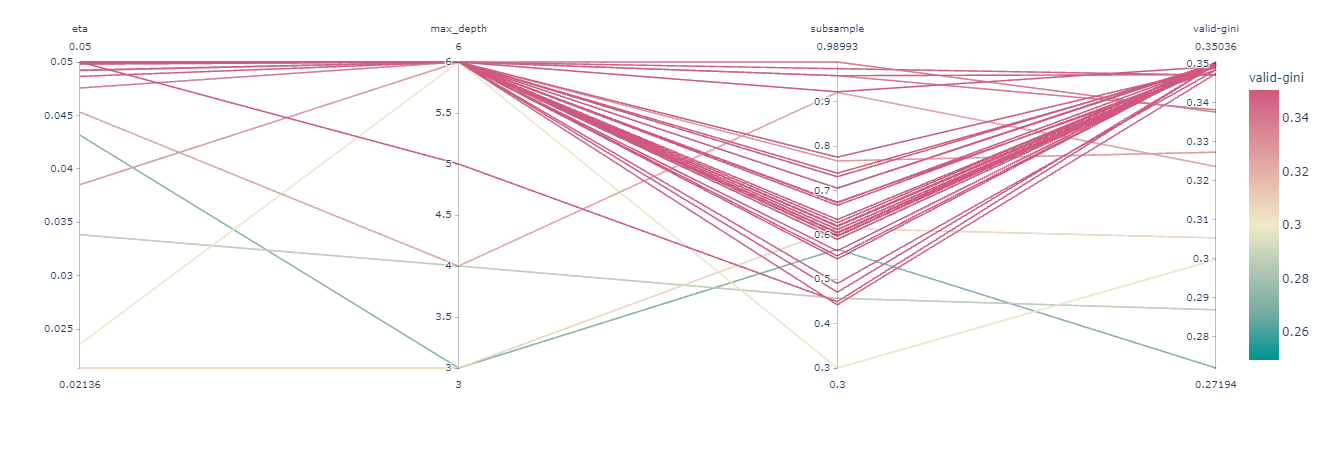

In [80]:
fig = px.parallel_coordinates(df, color="valid-gini", labels={"valid-gini": "valid-gini",
                "eta": "eta", "max_depth": "max_depth",
                "subsample": "subsample", },
                             color_continuous_scale=px.colors.diverging.Tealrose,
                             color_continuous_midpoint=0.3)
fig.show()